In [24]:
import pandas as pd
import numpy as np

from itertools import groupby
from scipy import spatial
from itertools import combinations

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


### Read file with counted codons

In [25]:
counted_codons = pd.read_csv("../data/counted_codons_cytb.csv")
counted_codons = counted_codons.drop("Gene", axis=1)
counted_codons  = counted_codons.drop("Unnamed: 0", axis=1)
counted_codons.head()


,Species,ExpectedObserved,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,...,A[G>C]A,A[G>T]A,A[G>T]G,A[G>T]T,A[T>A]A,A[T>A]G,A[T>A]T,A[T>G]A,A[T>G]G,A[T>G]T
0,Abbottina_obtusirostris,Expected,8.0,4.0,4.0,4.0,12.0,10.0,10.0,17.0,...,0,0,0,0,0,0,0,0,0,0
1,Abbottina_obtusirostris,Observed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Abbottina_rivularis,Expected,6.0,3.0,3.0,3.0,16.0,11.0,9.0,21.0,...,0,0,0,0,0,0,0,0,0,0
3,Abbottina_rivularis,Observed,2.0,1.0,0.0,1.0,6.0,4.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,Abramis_brama,Expected,9.0,3.0,4.0,5.0,8.0,9.0,9.0,18.0,...,0,0,0,0,0,0,0,0,0,0


###  Change format of table for better counting

In [26]:
_counted_codons = counted_codons.melt(["Species", "ExpectedObserved"], counted_codons.columns[2:], var_name="Mut")
_counted_codons.head()

,Species,ExpectedObserved,Mut,value
0,Abbottina_obtusirostris,Expected,A[A>G]A,8.0
1,Abbottina_obtusirostris,Observed,A[A>G]A,0.0
2,Abbottina_rivularis,Expected,A[A>G]A,6.0
3,Abbottina_rivularis,Observed,A[A>G]A,2.0
4,Abramis_brama,Expected,A[A>G]A,9.0


In [27]:
mutations = _counted_codons.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()
mutations.head()

ExpectedObserved,Species,Mut,Expected,Observed
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0


### Calculate RawMuspec for each species

In [28]:
mutations["RawMutSpec"] = (mutations["Observed"] / mutations["Expected"]).fillna(0)
mutations["RawMutSpec"] = mutations["RawMutSpec"].replace(np.inf, 0)
mutations.head()

ExpectedObserved,Species,Mut,Expected,Observed,RawMutSpec
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0


In [29]:
rawsum_df = mutations.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
rawsum_df.head()

,Species,RawMutSpecSum
0,Abbottina_obtusirostris,1.088889
1,Abbottina_rivularis,67.375092
2,Abramis_brama,8.375200
3,Acanthogobius_hasta,3.213889
4,Acanthopagrus_latus,0.154762


### Final Mutational spectrum

In [30]:
mutspecs = pd.merge(mutations, rawsum_df, on="Species")
mutspecs["MutSpec"] = mutspecs["RawMutSpec"] / mutspecs["RawMutSpecSum"]
mutspecs.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0,1.088889,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0,1.088889,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0,1.088889,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0,1.088889,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,1.088889,0.0


In [31]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

### Here we translate our mutspec with reverse on HEAVY CHAIN

In [32]:
mutspecs['Mut'] = mutspecs.Mut.apply(getrevers)
mutspecs["MutBase"] = mutspecs.Mut.str.slice(2, 5)
mutspecs["Context"] = mutspecs.Mut.str.get(0) + mutspecs.Mut.str.get(2) + mutspecs.Mut.str.get(-1)
mutspecs.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT


In [33]:
possible_sbs12 = [
    'A>C', 'A>G', 'A>T',
    'C>A', 'C>G', 'C>T',
    'G>A', 'G>C', 'G>T',
    'T>A', 'T>C', 'T>G'
]
possible_sbs192 = [
    "A[A>C]A", "A[A>C]C", "A[A>C]G", "A[A>C]T", "C[A>C]A", "C[A>C]C", "C[A>C]G", "C[A>C]T", 
    "G[A>C]A", "G[A>C]C", "G[A>C]G", "G[A>C]T", "T[A>C]A", "T[A>C]C", "T[A>C]G", "T[A>C]T", 
    "A[A>G]A", "A[A>G]C", "A[A>G]G", "A[A>G]T", "C[A>G]A", "C[A>G]C", "C[A>G]G", "C[A>G]T", 
    "G[A>G]A", "G[A>G]C", "G[A>G]G", "G[A>G]T", "T[A>G]A", "T[A>G]C", "T[A>G]G", "T[A>G]T", 
    "A[A>T]A", "A[A>T]C", "A[A>T]G", "A[A>T]T", "C[A>T]A", "C[A>T]C", "C[A>T]G", "C[A>T]T", 
    "G[A>T]A", "G[A>T]C", "G[A>T]G", "G[A>T]T", "T[A>T]A", "T[A>T]C", "T[A>T]G", "T[A>T]T", 
    "A[C>A]A", "A[C>A]C", "A[C>A]G", "A[C>A]T", "C[C>A]A", "C[C>A]C", "C[C>A]G", "C[C>A]T", 
    "G[C>A]A", "G[C>A]C", "G[C>A]G", "G[C>A]T", "T[C>A]A", "T[C>A]C", "T[C>A]G", "T[C>A]T", 
    "A[C>G]A", "A[C>G]C", "A[C>G]G", "A[C>G]T", "C[C>G]A", "C[C>G]C", "C[C>G]G", "C[C>G]T", 
    "G[C>G]A", "G[C>G]C", "G[C>G]G", "G[C>G]T", "T[C>G]A", "T[C>G]C", "T[C>G]G", "T[C>G]T", 
    "A[C>T]A", "A[C>T]C", "A[C>T]G", "A[C>T]T", "C[C>T]A", "C[C>T]C", "C[C>T]G", "C[C>T]T", 
    "G[C>T]A", "G[C>T]C", "G[C>T]G", "G[C>T]T", "T[C>T]A", "T[C>T]C", "T[C>T]G", "T[C>T]T", 
    "A[G>A]A", "A[G>A]C", "A[G>A]G", "A[G>A]T", "C[G>A]A", "C[G>A]C", "C[G>A]G", "C[G>A]T", 
    "G[G>A]A", "G[G>A]C", "G[G>A]G", "G[G>A]T", "T[G>A]A", "T[G>A]C", "T[G>A]G", "T[G>A]T", 
    "A[G>C]A", "A[G>C]C", "A[G>C]G", "A[G>C]T", "C[G>C]A", "C[G>C]C", "C[G>C]G", "C[G>C]T", 
    "G[G>C]A", "G[G>C]C", "G[G>C]G", "G[G>C]T", "T[G>C]A", "T[G>C]C", "T[G>C]G", "T[G>C]T", 
    "A[G>T]A", "A[G>T]C", "A[G>T]G", "A[G>T]T", "C[G>T]A", "C[G>T]C", "C[G>T]G", "C[G>T]T", 
    "G[G>T]A", "G[G>T]C", "G[G>T]G", "G[G>T]T", "T[G>T]A", "T[G>T]C", "T[G>T]G", "T[G>T]T", 
    "A[T>A]A", "A[T>A]C", "A[T>A]G", "A[T>A]T", "C[T>A]A", "C[T>A]C", "C[T>A]G", "C[T>A]T", 
    "G[T>A]A", "G[T>A]C", "G[T>A]G", "G[T>A]T", "T[T>A]A", "T[T>A]C", "T[T>A]G", "T[T>A]T", 
    "A[T>C]A", "A[T>C]C", "A[T>C]G", "A[T>C]T", "C[T>C]A", "C[T>C]C", "C[T>C]G", "C[T>C]T", 
    "G[T>C]A", "G[T>C]C", "G[T>C]G", "G[T>C]T", "T[T>C]A", "T[T>C]C", "T[T>C]G", "T[T>C]T", 
    "A[T>G]A", "A[T>G]C", "A[T>G]G", "A[T>G]T", "C[T>G]A", "C[T>G]C", "C[T>G]G", "C[T>G]T", 
    "G[T>G]A", "G[T>G]C", "G[T>G]G", "G[T>G]T", "T[T>G]A", "T[T>G]C", "T[T>G]G", "T[T>G]T", 
]


### Function to draw MutSpec

In [34]:
coloring12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "salmon",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "green",
    "A>G": "green",
    "T>G": "pink",
    "A>C": "pink",
}
colors12 = [coloring12[sbs] for sbs in possible_sbs12]

def plot_mutspec12(mutspec: pd.DataFrame, ylabel="MutSpec", title="Full mutational spectra", savepath=None):
    fig = plt.figure(figsize=(24, 12))
    ax = fig.add_subplot(111)
    ax = sns.barplot(x="Mut", y=ylabel, data=mutspec, order=possible_sbs12, ax=fig.gca())

    # map colors to bars
    for bar, clr in zip(ax.patches, colors12):
        bar.set_color(clr)

    ax.set_title(title)
    if savepath is not None:
        plt.savefig(savepath, dpi=300)
    plt.show()

def _add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black', linewidth=1)
    line.set_clip_on(False)
    ax.add_line(line)


def _label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]


def _label_group_bar_table(ax, df):
    font = {
        'family': 'Verdana',
        'color':  'black',
        'weight': 'normal',
        'size': 7,
    }
    rotation = 90
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        if level == 0:
            rotation = 0
            font['size'] = 12

        pos = 0
        for label, rpos in _label_len(df.index, level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', rotation=rotation,
                    fontdict=font, transform=ax.transAxes)
            if level == 0:
                _add_line(ax, pos*scale, ypos)
            pos += rpos
        if level == 0:
            _add_line(ax, pos*scale, ypos)
        ypos -= .05


def plot_mutspec192(edge_mutspec192, label="Mutational spectra", filepath=None):
    df = edge_mutspec192.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=(24, 12))
    ax = fig.add_subplot(111)
    sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec192,
                order=possible_sbs192, errwidth=1, ax=fig.gca())

    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_title(label)
    _label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    if filepath is not None:
        plt.savefig(filepath, dpi=300)
    plt.show()

### Plot Mutational Spectrum for all Vertebrates

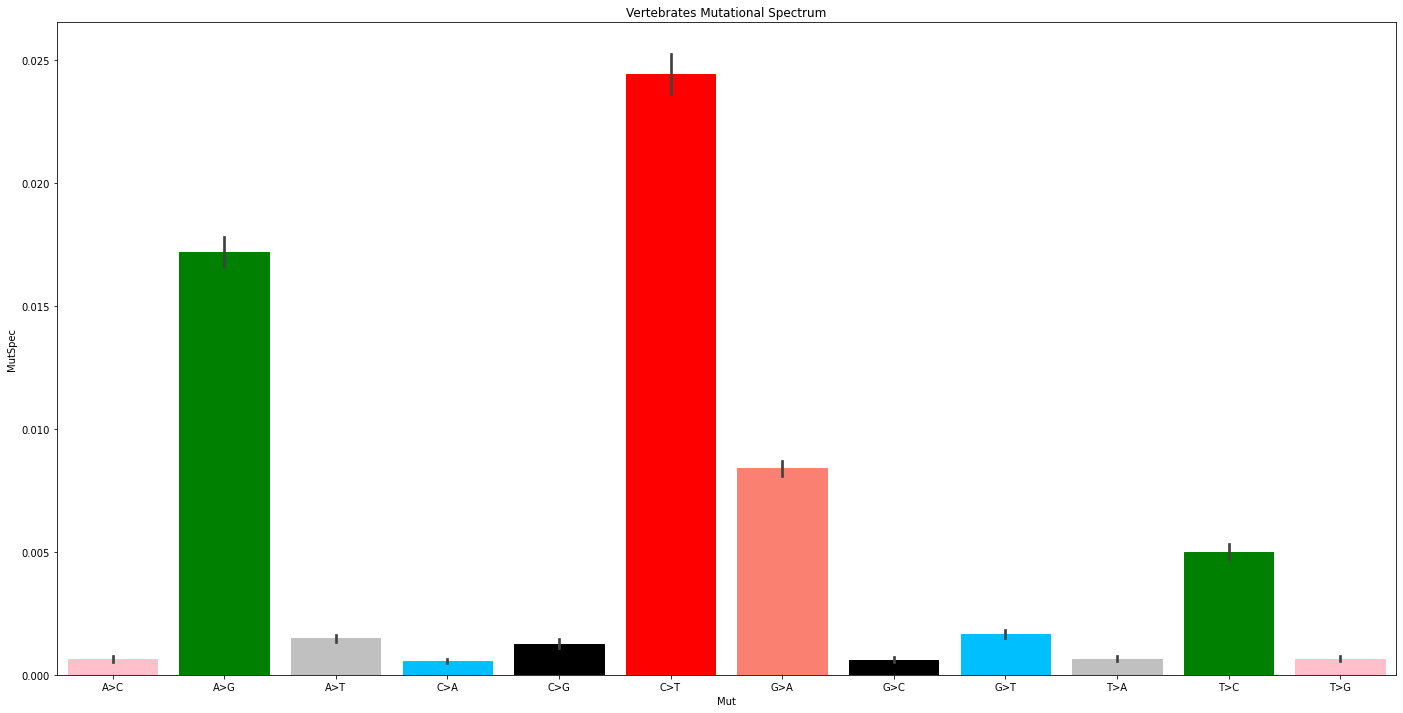

In [35]:
mut12_cont = mutspecs.drop('Mut', axis=1)
mut12_cont = mut12_cont.rename(columns={'MutBase':'Mut'})
plot_mutspec12(mut12_cont, title='Vertebrates Mutational Spectrum')

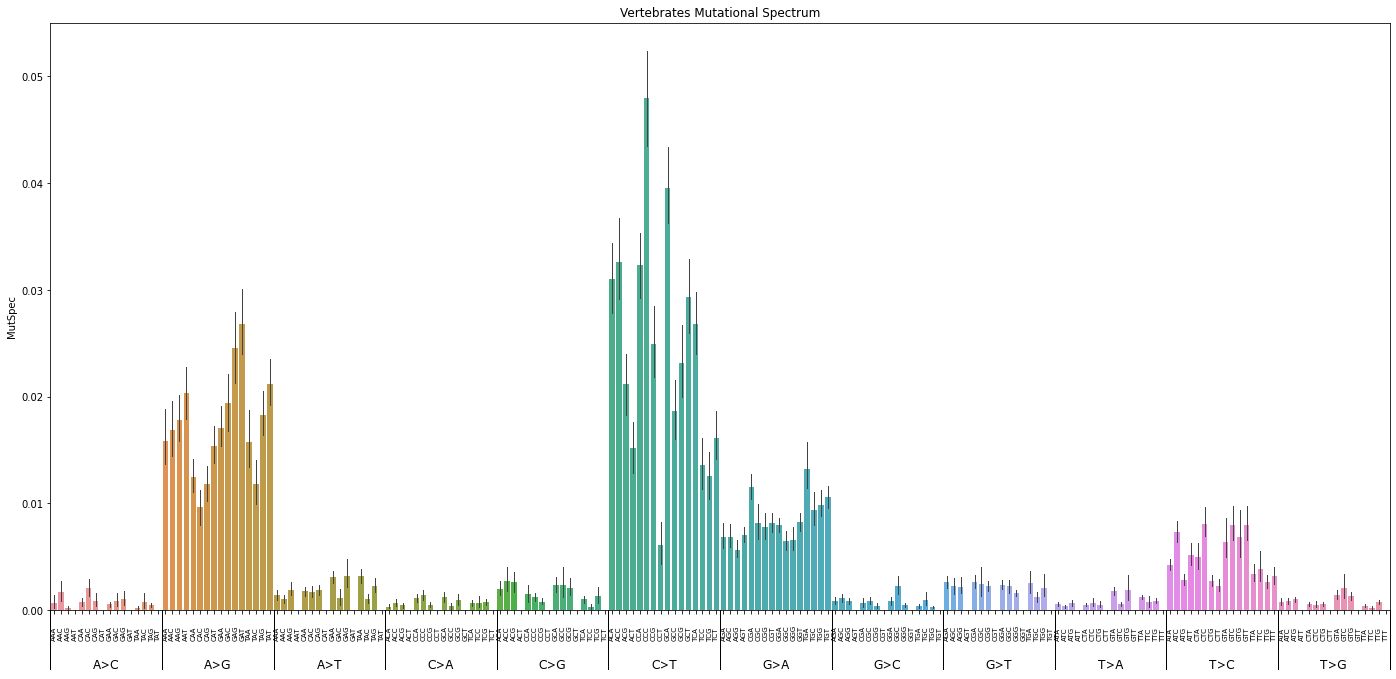

In [36]:
plot_mutspec192(mutspecs, label='Vertebrates Mutational Spectrum')

### Add taxonomy and get mutspec for 5 orders

In [37]:
taxa = pd.read_csv('../data/taxa_gb.csv', sep='\t')
taxa.head()

,Class,Species
0,Aves,Corvus_frugilegus
1,Mammalia,Rhinopithecus_bieti
2,Mammalia,Cheracebus_lugens
3,Mammalia,Chiropotes_israelita
4,Mammalia,Callimico_goeldii


### How many classes we have

How many classes obtained from mutspec

In [38]:
taxa['Class'].value_counts()

Actinopterygii    2855
Mammalia          1464
Aves              1007
Amphibia           325
Lepidosauria       294
Name: Class, dtype: int64

How many species by classes left after merging with mutspec

In [39]:
final_mutspec = pd.merge(mutspecs, taxa, on='Species')
final_mutspec = final_mutspec.drop_duplicates()

In [40]:
final_mutspec['Class'].value_counts()//192

Actinopterygii    457
Mammalia          384
Aves               72
Lepidosauria       36
Amphibia           25
Name: Class, dtype: int64

How many species we have

In [41]:
len(final_mutspec.Species.unique())

974

In [42]:
# save mutspec of cytb for all vertebrates
final_mutspec.to_csv('../data/MutSpecVertebratescytb.csv', index=False)

### Draw Mutational Spectra for different classes

In [43]:
taxes_to_draw = ['Mammalia', 'Aves', 'Actinopterygii', 'Lepidosauria', 'Amphibia']

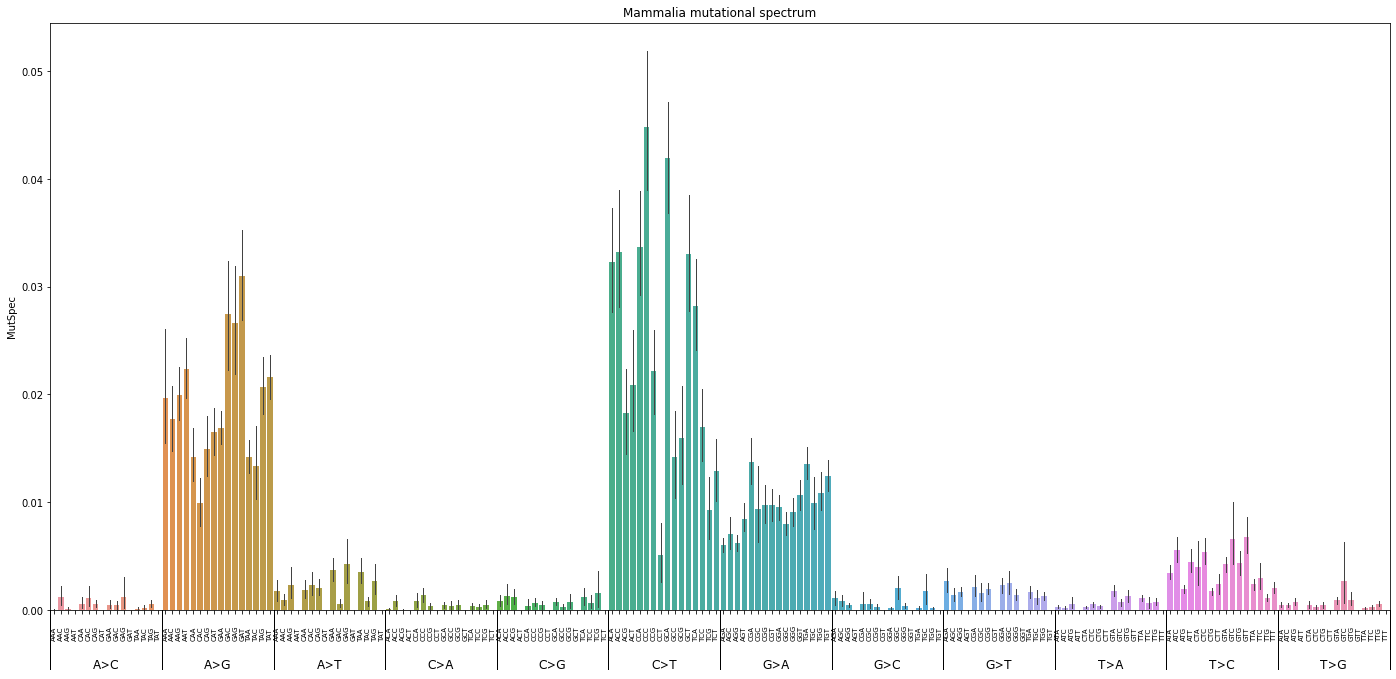

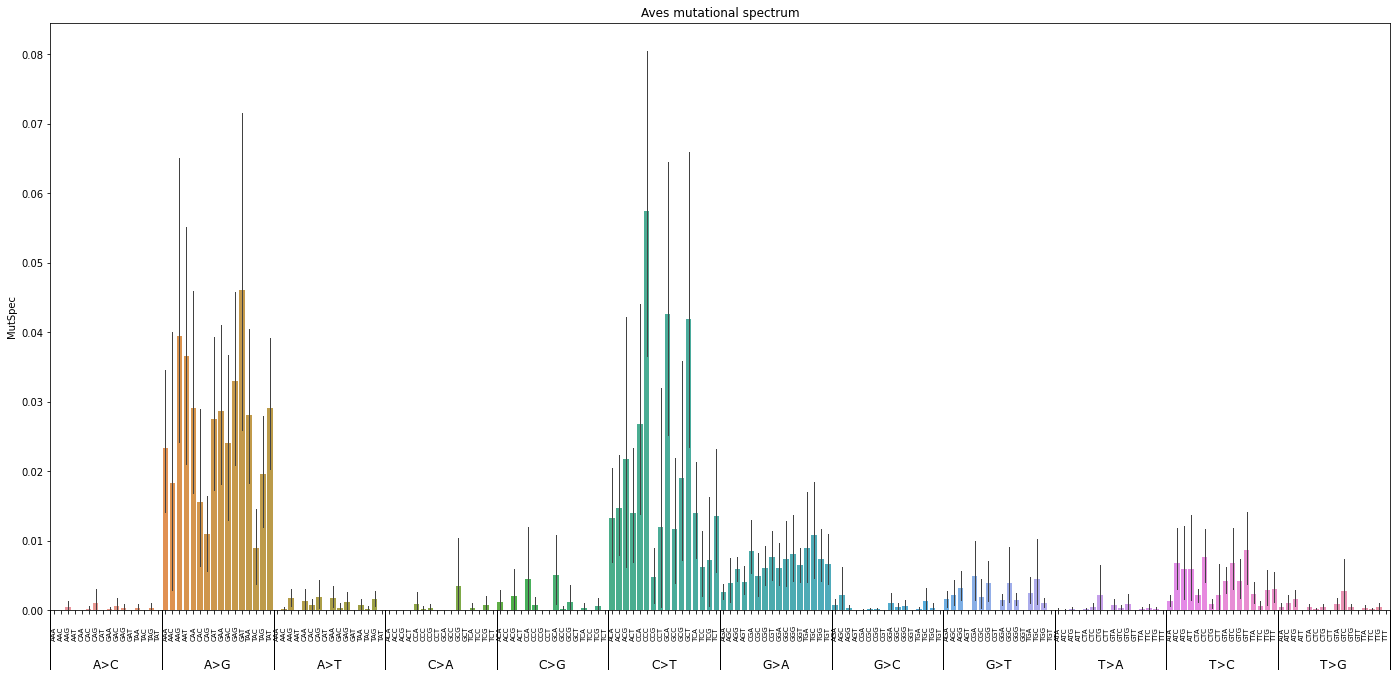

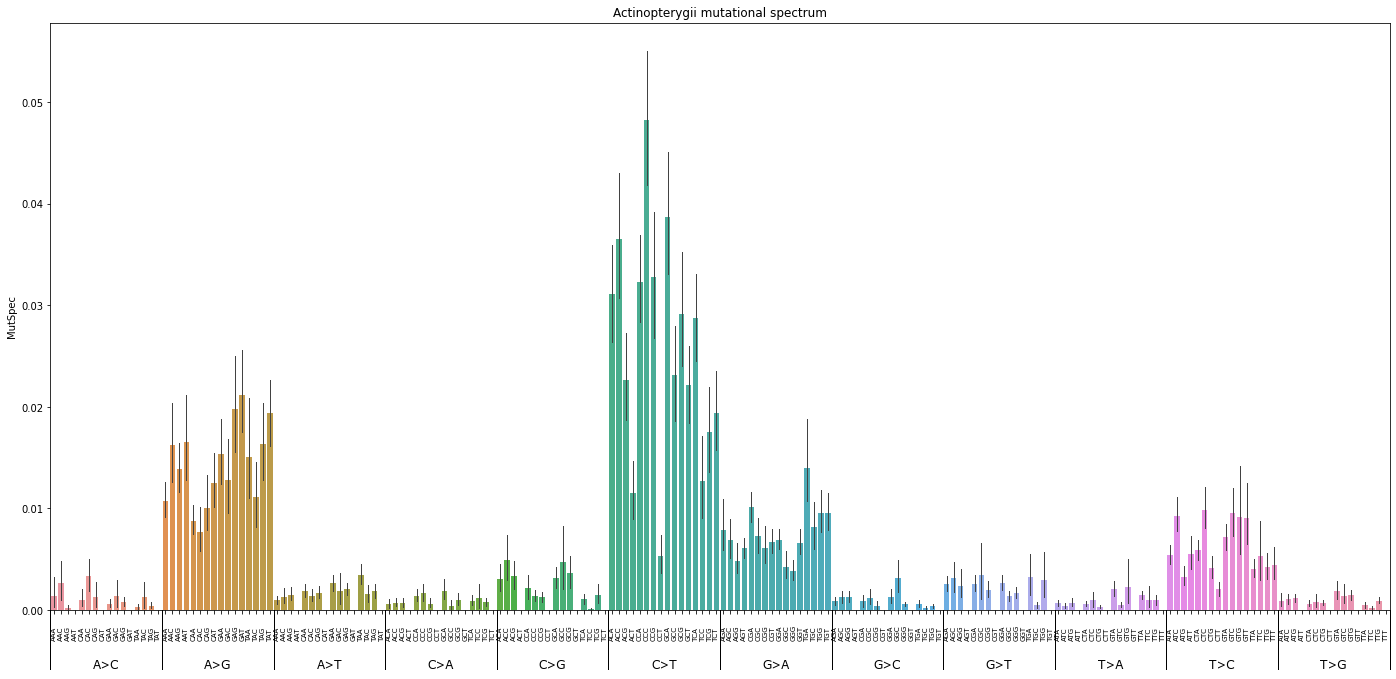

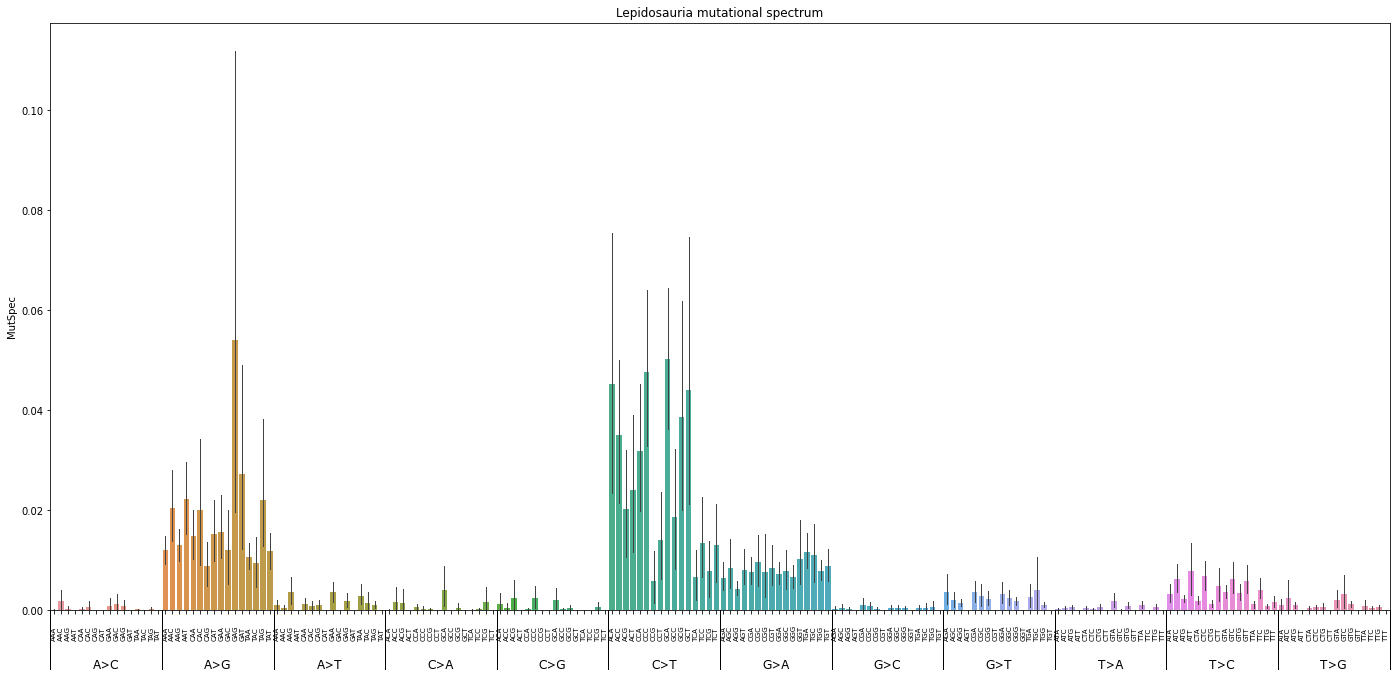

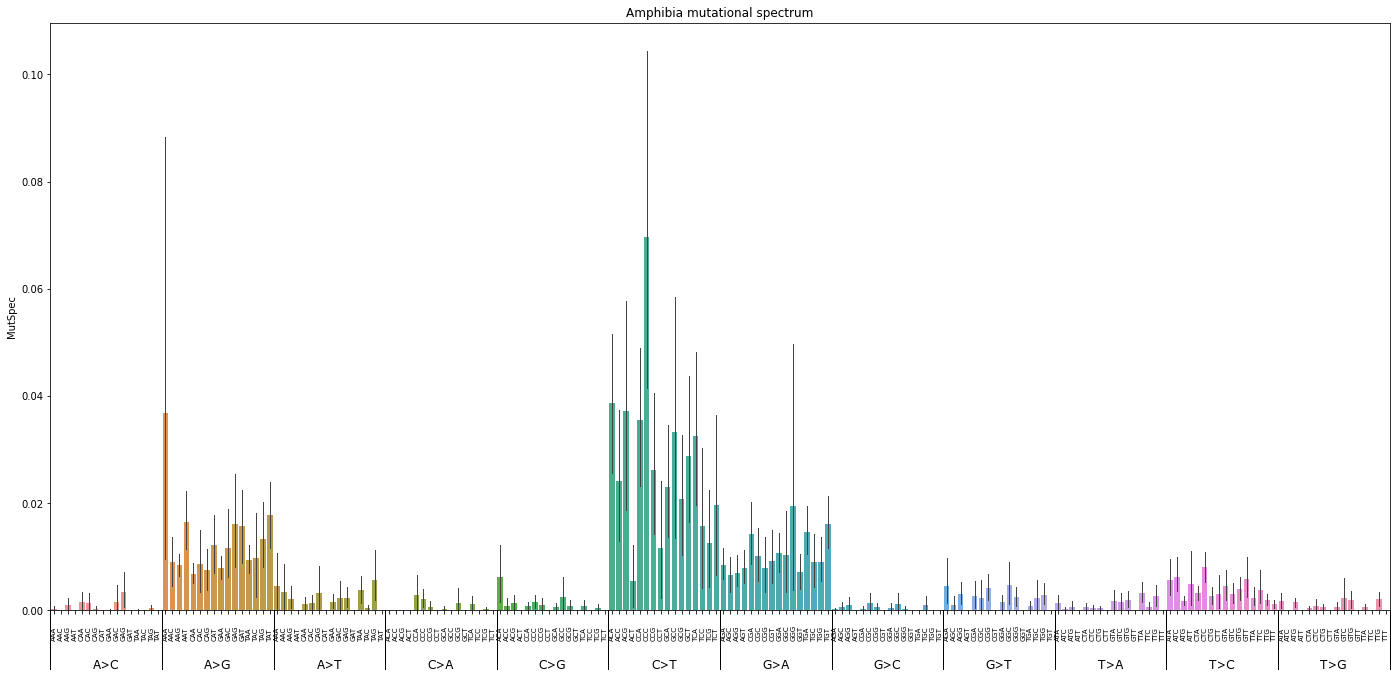

In [44]:
for tax in taxes_to_draw:
    plot_mutspec192(final_mutspec[final_mutspec['Class'] == tax], label=f'{tax} mutational spectrum')

## Analys of similarity

In [45]:
needed_classes = ['Mammalia', 'Aves', 'Amphibia', 'Lepidosauria', 'Actinopterygii', 'exdloop']

### Calculate mean mutspec for each class 

In [46]:
final_mutspec.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [51]:
ms_cls = final_mutspec.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
ms_cls.tail()

,Class,Mut,MutSpec
955,Mammalia,T[T>C]T,0.001858
956,Mammalia,T[T>G]A,0.000303
957,Mammalia,T[T>G]C,0.000388
958,Mammalia,T[T>G]G,0.000603
959,Mammalia,T[T>G]T,0.000000


## Download cancer mutspec 

In [52]:
cancer = pd.read_csv('../data/external/cancer_mutspec.csv')
cancer = cancer.loc[:,['Mut','MutSpec_ExDloop']]

In [53]:
cancer.head()

,Mut,MutSpec_ExDloop
0,A[A>C]A,0.000000
1,A[A>C]C,0.000783
2,A[A>C]G,0.000000
3,A[A>C]T,0.000084
4,A[A>G]A,0.008273


In [54]:
exdloop = cancer.iloc[:,[0,1]]
exdloop['Class'] = 'exdloop'
exdloop = exdloop.rename(columns={'MutSpec_ExDloop': 'MutSpec'})


In [27]:
to_cosinus = pd.concat([exdloop, ms_cls])
to_cosinus.head()

,Mut,MutSpec,Class
0,A[A>C]A,0.000000,exdloop
1,A[A>C]C,0.000783,exdloop
2,A[A>C]G,0.000000,exdloop
3,A[A>C]T,0.000084,exdloop
4,A[A>G]A,0.008273,exdloop


### Calculate similarities for each combination of observed classes

In [28]:
def similarity_count(count_sim_df):
    to_heatmap = []
    for comb1 in needed_classes:
        for comb2 in needed_classes:
            cos192 = spatial.distance.cosine(
                        count_sim_df[count_sim_df['Class'] == comb1].MutSpec,
                        count_sim_df[count_sim_df['Class'] == comb2].MutSpec 
                    )
            # print(f'Similarity btw {comb[0]} and {comb[1]} is {1-cos192}')
            cos_res = {'Class1':comb1, 'Class2':comb2, 'Similarity':1-cos192}
            to_heatmap.append(cos_res)
    return pd.DataFrame(to_heatmap)

### Draw heatmap of similarities

In [29]:
all_heatmap = similarity_count(to_cosinus)
all_heatmap = all_heatmap.pivot('Class2', 'Class1', 'Similarity')
matrix = np.triu(all_heatmap)

In [30]:
all_heatmap.iloc[1:, 1:]

Class1,Amphibia,Aves,Lepidosauria,Mammalia,exdloop
Class2,,,,,
Amphibia,1.000000,0.860298,0.874431,0.931121,0.808224
Aves,0.860298,1.000000,0.859726,0.930052,0.691312
Lepidosauria,0.874431,0.859726,1.000000,0.928541,0.799935
Mammalia,0.931121,0.930052,0.928541,1.000000,0.778354
exdloop,0.808224,0.691312,0.799935,0.778354,1.000000


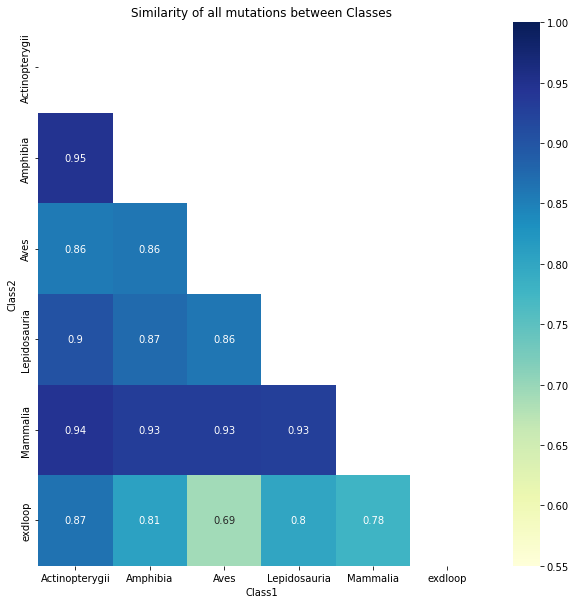

In [31]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(all_heatmap, annot=True, mask=matrix, cmap="YlGnBu", vmin =0.55, vmax=1)
ax.set_title('Similarity of all mutations between Classes')
#plt.savefig('../pictures/SimilarityHeatMap.pdf', dpi=300)

### Make similarity only for Transitions and Transversions

In [32]:
TS_vec = ['A>G', 'G>A', 'T>C', 'C>T']
TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']

In [33]:
to_cosinus["MutBase"] = to_cosinus.Mut.str.slice(2, 5)

In [34]:
TS_df = to_cosinus[to_cosinus['MutBase'].isin(TS_vec)]
TV_df = to_cosinus[to_cosinus['MutBase'].isin(TV_vec)]

In [35]:
ts_heatmap = similarity_count(TS_df).pivot('Class2', 'Class1', 'Similarity')
tv_heatmap = similarity_count(TV_df).pivot('Class2', 'Class1', 'Similarity')
matrix_ts = np.triu(ts_heatmap)
matrix_tv = np.triu(tv_heatmap)

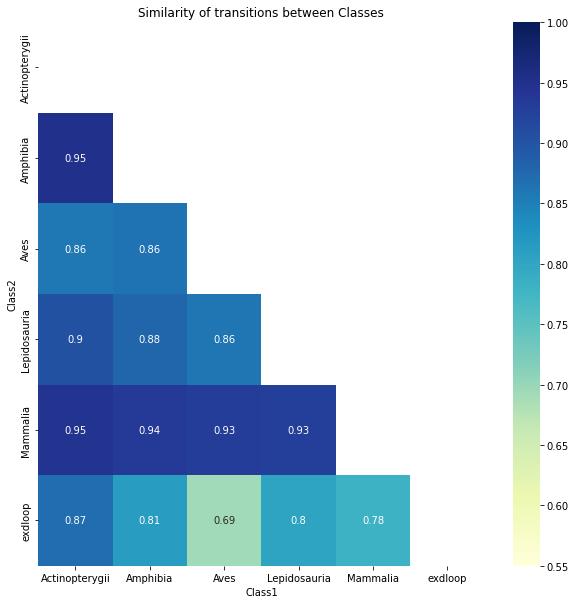

In [36]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(ts_heatmap, annot=True, mask=matrix_ts, cmap="YlGnBu", vmin=0.55, vmax=1)
ax.set_title('Similarity of transitions between Classes')
#plt.savefig('../pictures/SimilarityTSHeatMap.pdf', dpi=300)

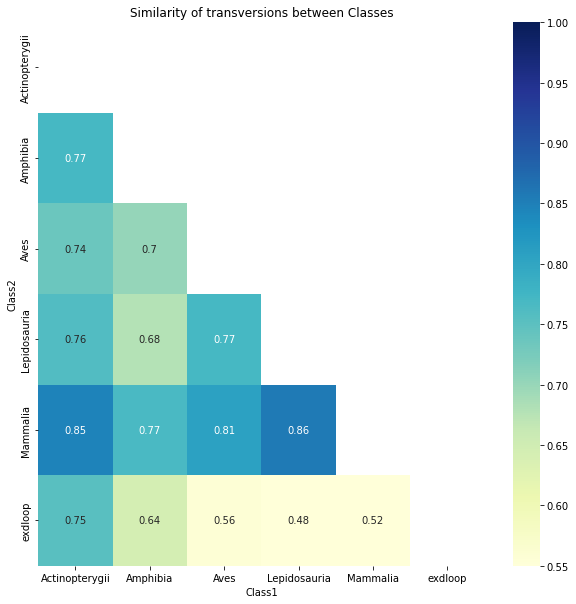

In [37]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(tv_heatmap, annot=True, mask=matrix_tv, cmap="YlGnBu", vmin = 0.55, vmax=1)
ax.set_title('Similarity of transversions between Classes')
#plt.savefig('../pictures/SimilarityTVHeatMap.pdf', dpi=300)

### Analysis of C>T on heavy chain as a hallmark of oxidative damage

In [46]:
mutspecs.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT


In [56]:
CT_only = final_mutspec[final_mutspec['MutBase'] == 'C>T']

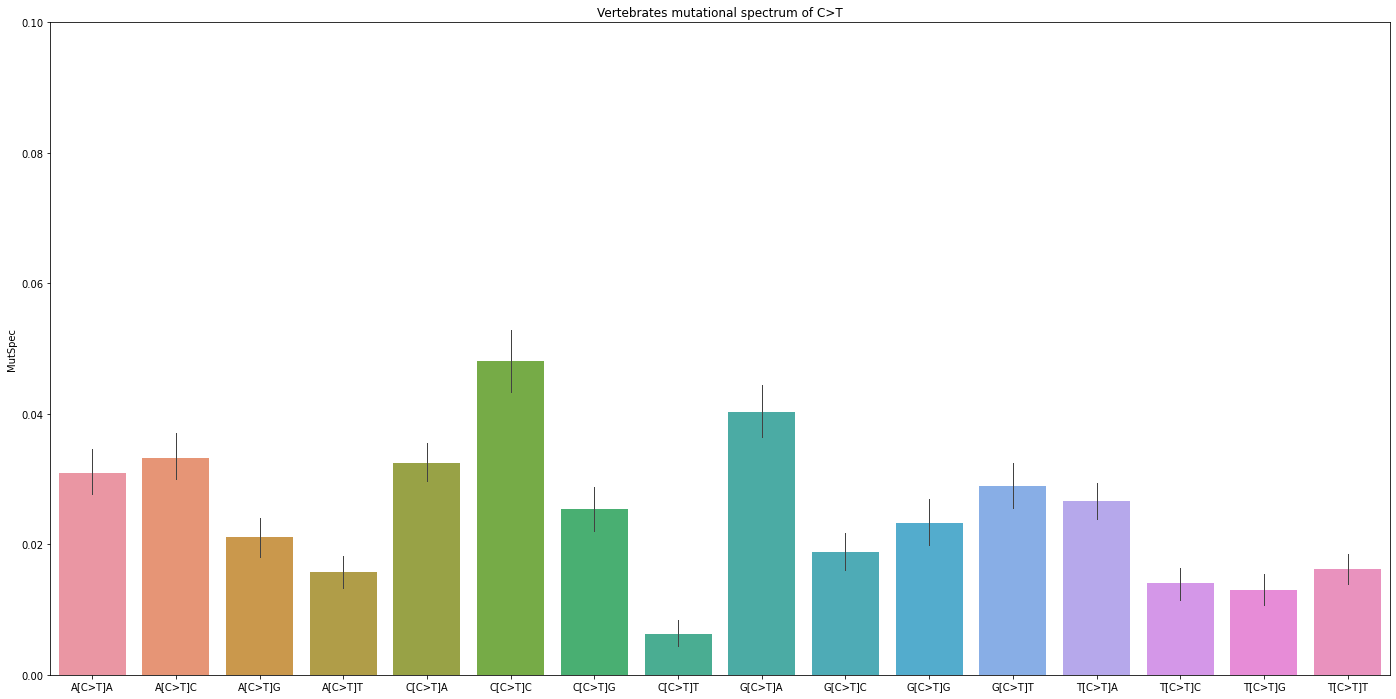

In [57]:
C_T_arr = ["A[C>T]A", "A[C>T]C", "A[C>T]G", "A[C>T]T", "C[C>T]A", "C[C>T]C", "C[C>T]G", "C[C>T]T", 
    "G[C>T]A", "G[C>T]C", "G[C>T]G", "G[C>T]T", "T[C>T]A", "T[C>T]C", "T[C>T]G", "T[C>T]T"]
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
sns.barplot(x="Mut", y="MutSpec", data=CT_only,
            order=C_T_arr, errwidth=1, ax=fig.gca())
ax.set_xlabel('')
ax.set_title('Vertebrates mutational spectrum of C>T')
ax.set_ylim(0,0.10)
#plt.savefig('../pictures/CTMutVert.pdf',dpi=300)
plt.show()

(-0.15, 0.6)

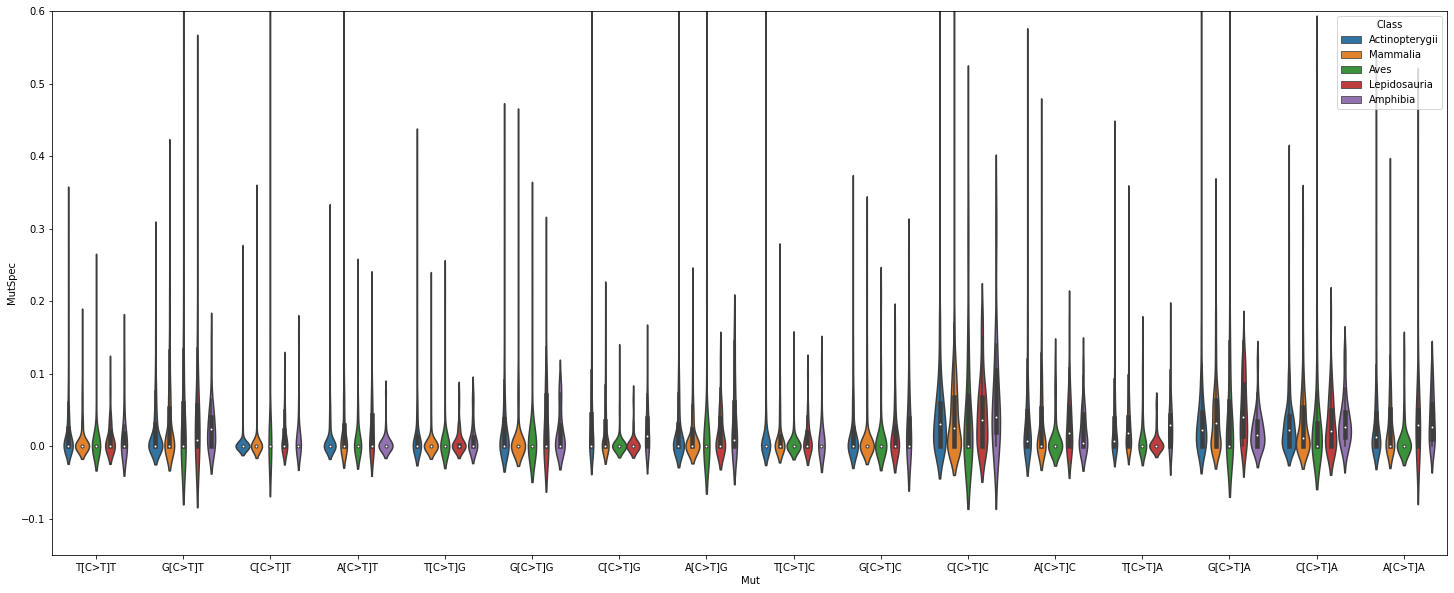

In [58]:
plt.figure(figsize=(25,10))
ax = sns.violinplot(data=CT_only, x='Mut', y='MutSpec', hue='Class')
ax.set_ylim(-0.15, 0.6)

In [50]:
ct_taxa = pd.merge(CT_only,taxa, on='Species')

In [51]:
ct_taxa.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[C>T]T,0.0,0.0,0.0,1.088889,0.0,C>T,TCT,Actinopterygii
1,Abbottina_obtusirostris,G[C>T]T,0.0,0.0,0.0,1.088889,0.0,C>T,GCT,Actinopterygii
2,Abbottina_obtusirostris,C[C>T]T,0.0,0.0,0.0,1.088889,0.0,C>T,CCT,Actinopterygii
3,Abbottina_obtusirostris,A[C>T]T,1.0,0.0,0.0,1.088889,0.0,C>T,ACT,Actinopterygii
4,Abbottina_obtusirostris,T[C>T]G,1.0,0.0,0.0,1.088889,0.0,C>T,TCG,Actinopterygii


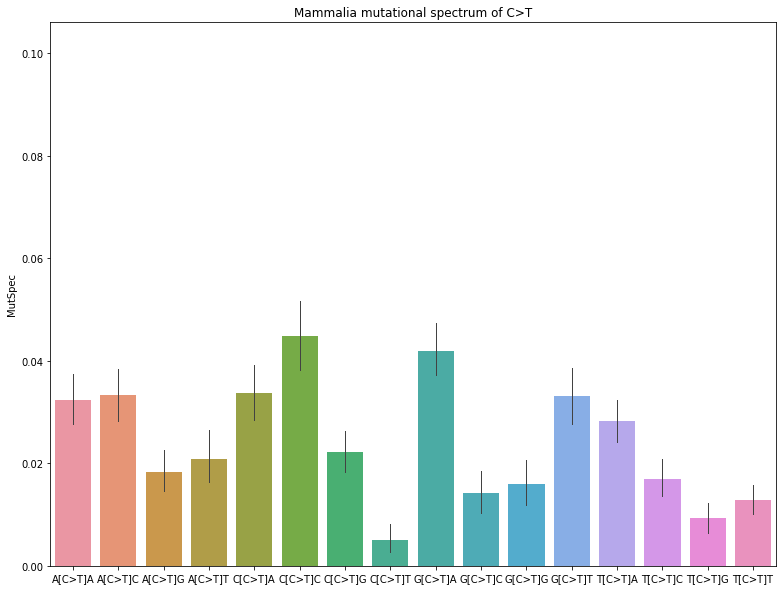

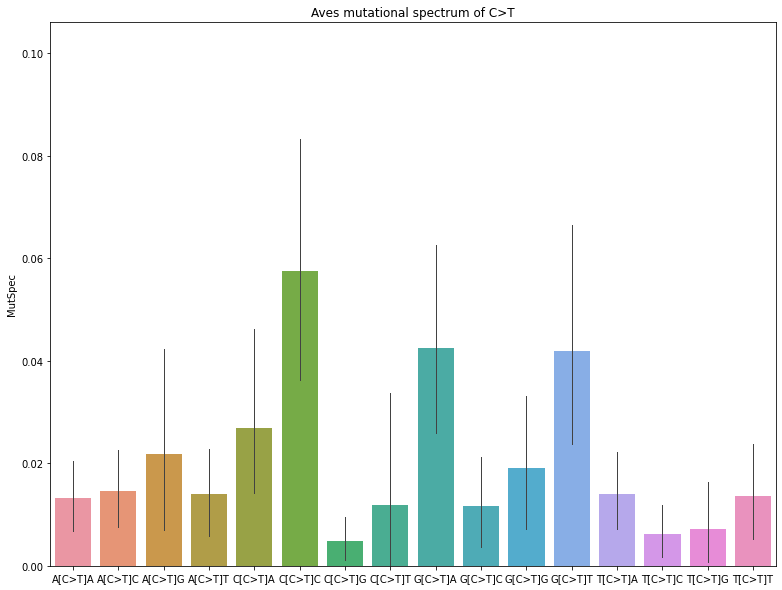

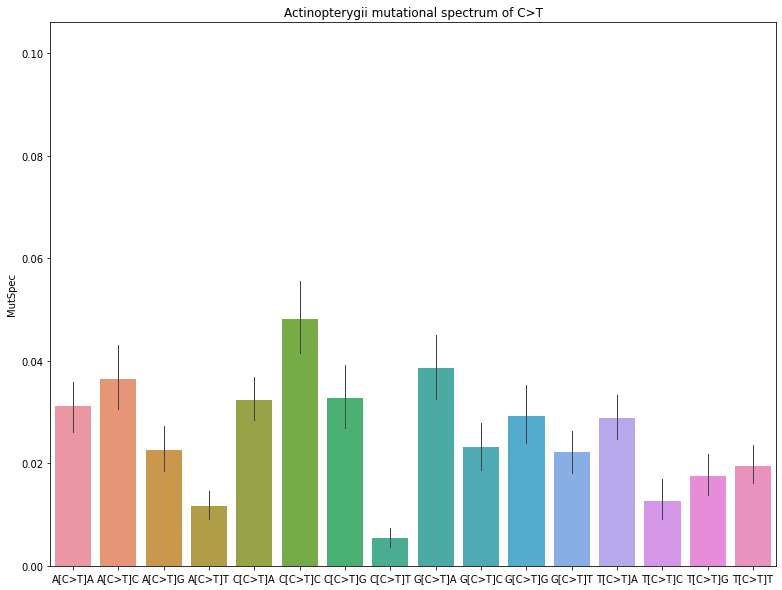

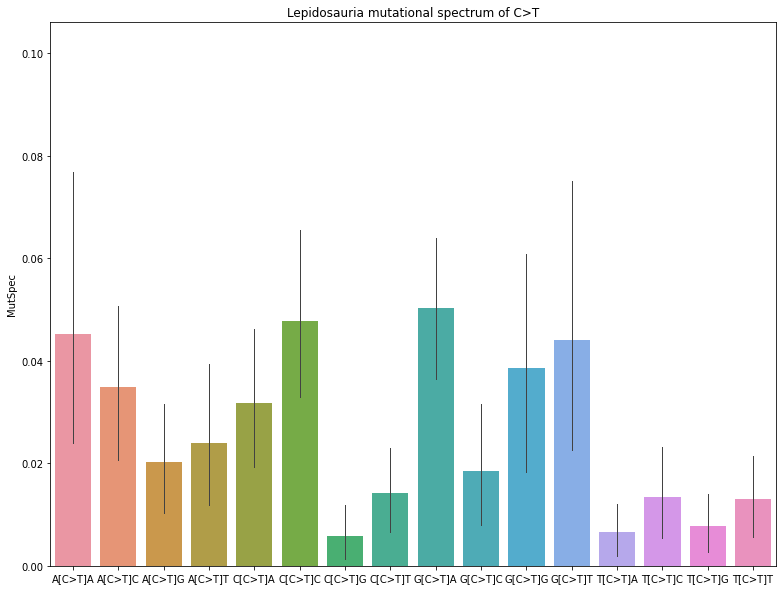

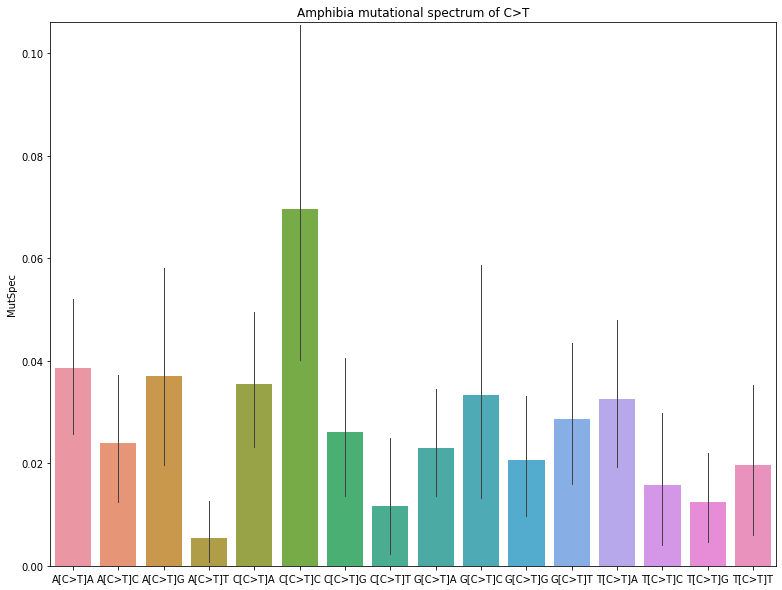

In [226]:
for tx in taxes_to_draw:
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_subplot(111)   
    sns.barplot(x="Mut", y="MutSpec", data=ct_taxa[ct_taxa.Class == tx],
                order=C_T_arr, errwidth=1, ax=fig.gca())
    ax.set_xlabel('')
    ax.set_title(f'{tx} mutational spectrum of C>T')
    ax.set_ylim(0, 0.106)


### Analysis of A>G on heavy chain as a hallmark of 6MA

In [52]:
AG_only = mutspecs[mutspecs['MutBase'] == 'A>G']
ag_taxa = pd.merge(AG_only,taxa, on='Species')
A_G_arr = ["A[A>G]A", "A[A>G]C", "A[A>G]G", "A[A>G]T", "C[A>G]A", "C[A>G]C", "C[A>G]G", "C[A>G]T", 
    "G[A>G]A", "G[A>G]C", "G[A>G]G", "G[A>G]T", "T[A>G]A", "T[A>G]C", "T[A>G]G", "T[A>G]T"]
    

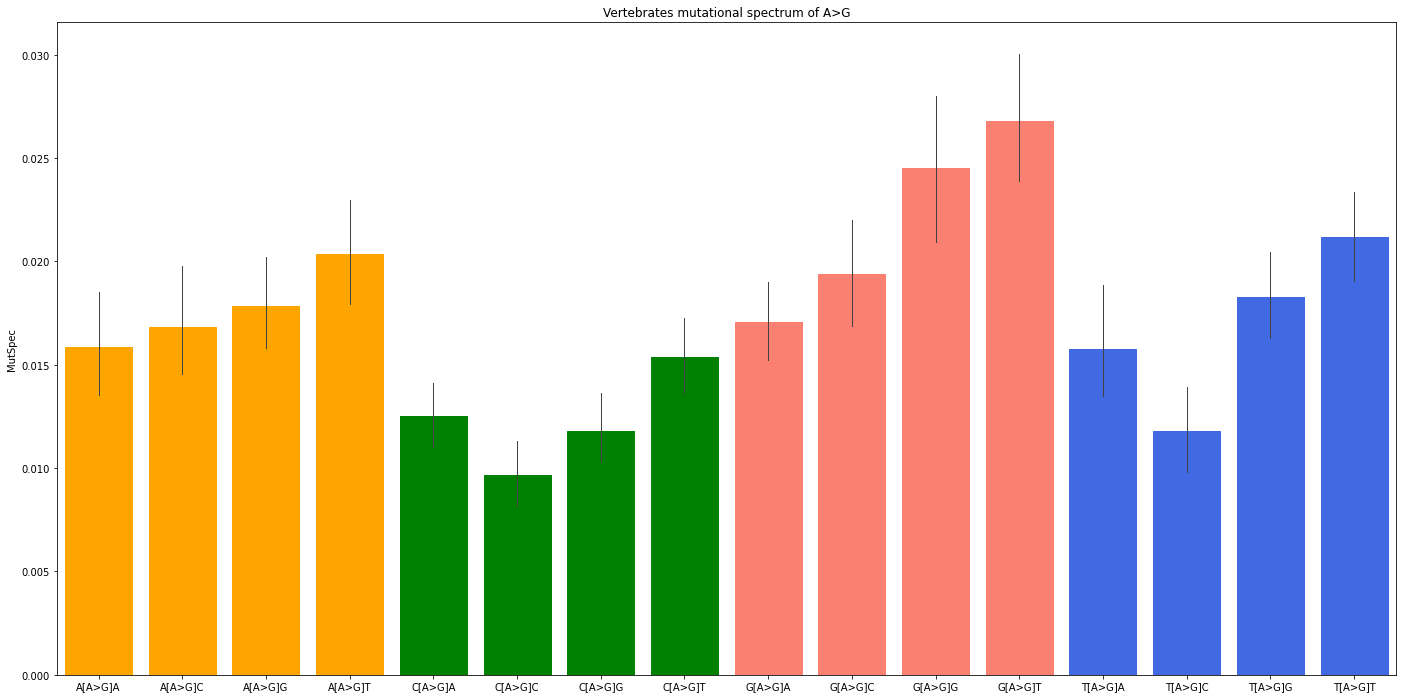

In [53]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
sns.barplot(x="Mut", y="MutSpec", data=AG_only,
            order=A_G_arr, errwidth=1, ax=fig.gca())
colorsAG = ['orange','orange','orange','orange','green','green','green','green',
            'salmon','salmon','salmon','salmon','royalblue','royalblue','royalblue','royalblue']
for bar, clr in zip(ax.patches, colorsAG):
        bar.set_color(clr)
ax.set_xlabel('')
ax.set_title('Vertebrates mutational spectrum of A>G')
plt.savefig('../pictures/AGMutVert.pdf',dpi=300)
plt.show()

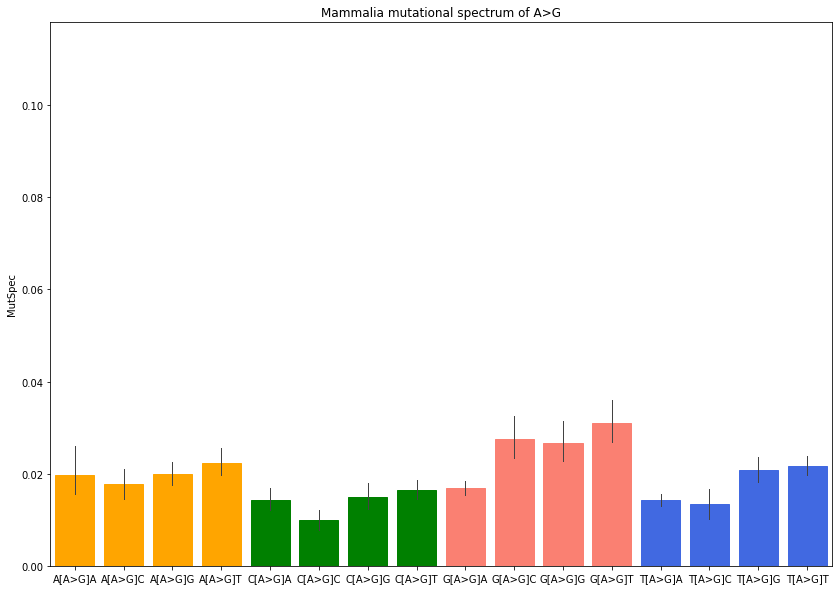

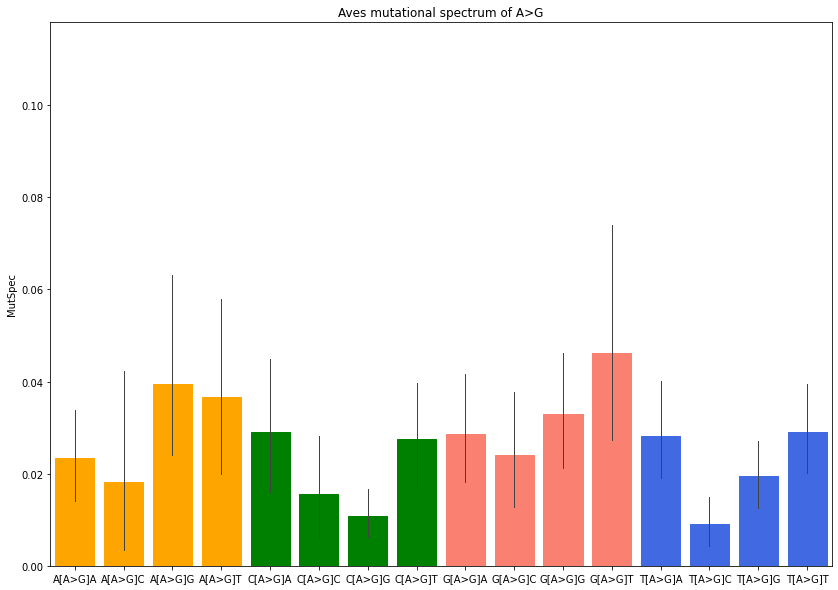

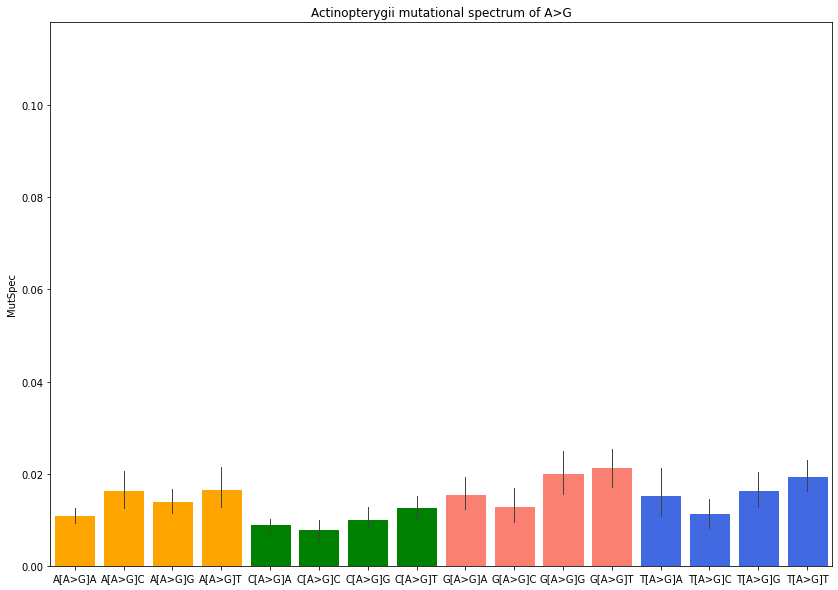

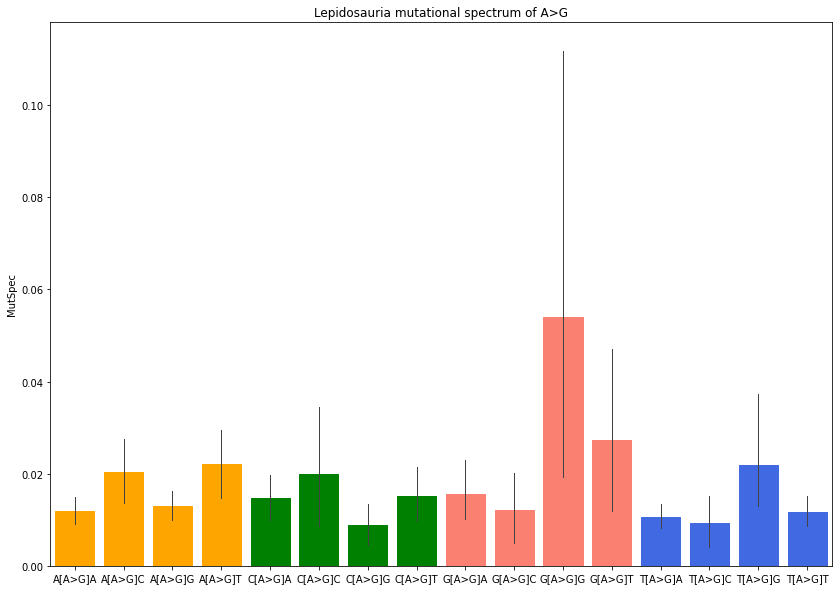

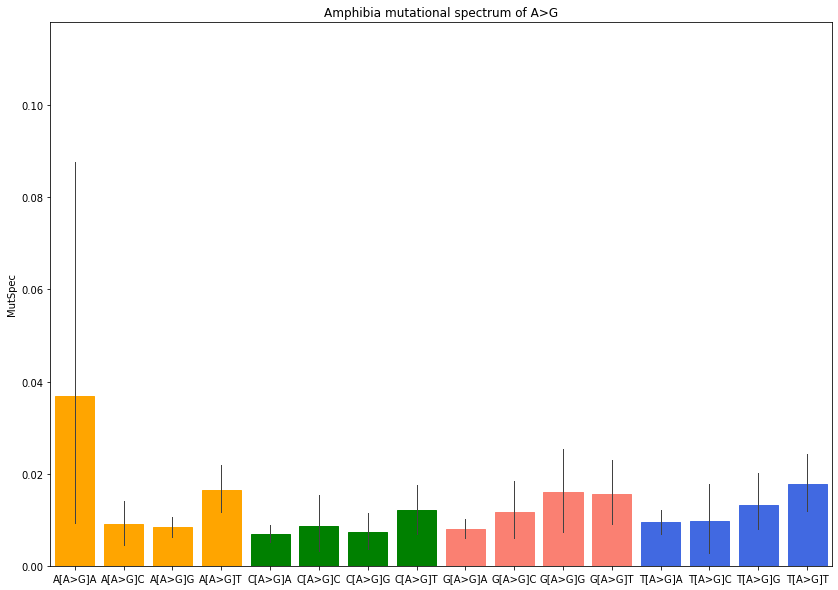

In [251]:
for tx in taxes_to_draw:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)   
    sns.barplot(x="Mut", y="MutSpec", data=ag_taxa[ag_taxa.Class == tx],
                order=A_G_arr, errwidth=1, ax=fig.gca())
    for bar, clr in zip(ax.patches, colorsAG):
        bar.set_color(clr)
    ax.set_xlabel('')
    ax.set_title(f'{tx} mutational spectrum of A>G')
    ax.set_ylim(0, 0.118)